In [ ]:
## APPENDIX 1
## Daniel Marten - Submitted: 12/4/2021
## Project 2 - ECE 566

# NOTE: Revisions made for interviews in Spring 2022

# Importing packages, standard from code
# tensorflow.keras
# additionally imported Batch Normalization which helps noisey data

%matplotlib inline
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adadelta, Adam, SGD
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, Flatten, AveragePooling2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import BatchNormalization

from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
os.chdir("/content/gdrive/My Drive/Colab Notebooks") # Points to my own Google Drive Folder
# may correct later
# importing everything

Mounted at /content/gdrive


In [ ]:
data = np.load('./MNIST_CorrNoise.npz') # Importing the dataset which includes noise
# this is a LOT of noise oh my goodness

Number of classes: 10
x train shape as: (60000, 28, 28)
pixel count as: 784
Examples of handwritten digit with correlated noise: 



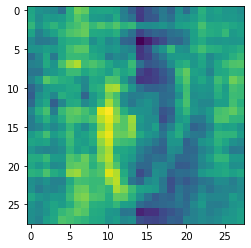

Class: 0



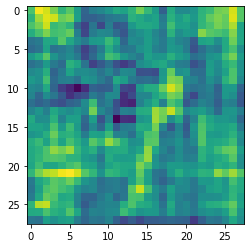

Class: 9



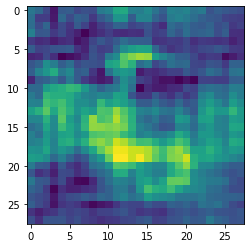

Class: 5



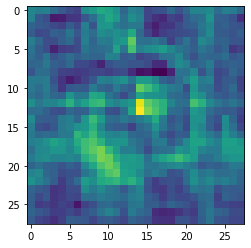

Class: 0



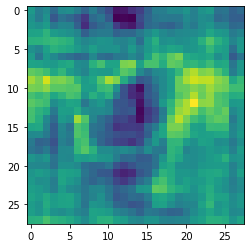

Class: 9



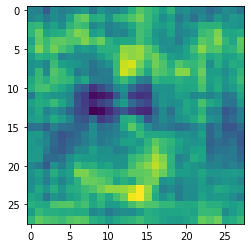

Class: 5



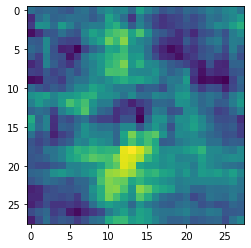

Class: 7



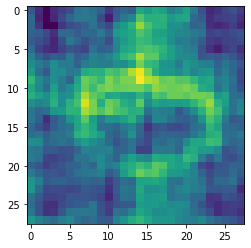

Class: 0



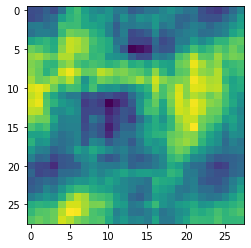

Class: 7



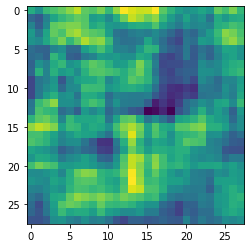

Class: 1

Shape of x_train: (60000, 28, 28, 1)
Shape of y_train: (60000, 10)


In [ ]:
x_train = data['x_train'] # Defining the training data
y_train = data['y_train']

num_cls = len(np.unique(y_train)) # Defining the number of classes
print('Number of classes: ' + str(num_cls))

print("x train shape as: " + str(x_train.shape))
pixelCount = x_train.shape[1]*x_train.shape[2] # Calculates size of the total number of pixels
# this is used for the first Density layer, seen below
print("pixel count as: " + str(pixelCount))
# pixelCount = x_train.shape[1]**2 ## ASSUMES SQUARE 

print('Examples of handwritten digit with correlated noise: \n')

kImg = [500*x for x in range(2,12)] # 10 handwritten digits to show the extent of the noise

#k = 3001 these are actually very hard to tell sometimes
# SHOWING said noise

for k in kImg:
  plt.imshow(np.squeeze(x_train[k,:,:]))
  plt.show()
  print('Class: '+str(y_train[k])+'\n')

# RESHAPE and standarize
x_train = np.expand_dims(x_train/255,axis=3) # standardizing to make working easier

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_cls)

print('Shape of x_train: '+str(x_train.shape))
print('Shape of y_train: '+str(y_train.shape))

# print(x_train[k])
# print(y_train[k])

# when working with things like the Sigmoid function and other activiation functions,
# centering around 0 and having ranges from -1STDEV to 1STDEV is ALWAYS important
# some activation functions are better than other for this, though



In [ ]:
# Defining a model
# As a function, ONLY works with our dataset
# Pick from Adadelta, Adam, SGD -- CASE SENSITIVE

input_shape = x_train.shape[1:4] #(28,28,1) # Set-up work, defining shape 

if not os.path.exists('./weights'):
  os.mkdir('./weights') # making sure there is a place for weights to be stores


# THE BELOW IS WHERE A MAJORITY OF WORK IN THIS PROJECT IS DONE
# IT CONTAINS THE DESIGN OF THE CONVOLUTED NEURAL NETWORK
# dmModel for Daniel Marten's Model
def dmModel(layer1num,layer2num,bVal,eVal,vVal,verboseVal=1,modelName="testName",batch=True,optimizer='Adadelta',reduce=False,earlyStop=False,eStopVal=0.01,eStopPatience=1):
  
  #print("we are initializing!!!")
  # default optimizer of Adadelta
  pweight='./weights/weights_'+modelName+'.hdf5' # defining where the weights will be stores and starting the movdl
  model = Sequential()

  # MODEL DESIGN: 
  # Conv2D
  # Batch Normalization
  # Max Pooling
  # Dropout
  # Conv2D
  # Batch Normalization
  # Max Pooling
  # Dropout
  # Flatten
  # Dense #1
  # Dense #2

  # START layer design
  model.add(Conv2D(layer1num, kernel_size=(5, 5), activation='relu', input_shape=input_shape)) # explore num channels and adding more layers
  if (batch==True):
    model.add(BatchNormalization()) # reduces noise
  model.add(MaxPooling2D()) # pooling

  model.add(Dropout(0.2)) # reduces overfitting

  # Repeat the block of code above

  model.add(Conv2D(layer2num, kernel_size=(3,3), activation='relu',input_shape=input_shape))
  if (batch==True):
    model.add(BatchNormalization())
  model.add(MaxPooling2D())

  model.add(Dropout(0.2)) # further reduces overfitting

  model.add(Flatten())
  model.add(Dense(pixelCount, activation='relu')) # could optimize these values, did not have time
  model.add(Dense(num_cls, activation='softmax'))
  #END layers

  # THREE optimizers, of which SGD and Adam are preferred over the default Adadelta
  if (optimizer == 'SGD'):
    model.compile(loss=categorical_crossentropy,
      optimizer=SGD(), # explore other optimizers: Adam, SGD
      metrics=['accuracy'])
  elif (optimizer == 'Adam'):
    model.compile(loss=categorical_crossentropy,
      optimizer=Adam(), # explore other optimizers: Adam, SGD
      metrics=['accuracy'])
  else:
    model.compile(loss=categorical_crossentropy,
      optimizer=Adadelta(), # explore other optimizers: Adam, SGD
      metrics=['accuracy'])
    
  model.summary()

  checkpointer = ModelCheckpoint(filepath=pweight, verbose=verboseVal, save_best_only=True, monitor='val_accuracy')
  callbacks_list = [checkpointer] # explore adding other callbacks such as ReduceLROnPlateau, EarlyStopping
  
  if (reduce==True):
    lr = ReduceLROnPlateau(monitor='val_accuracy',patience=1,factor=0.1,min_delta=0.01,verbose=1) 
    # lowers learning rate at platuea
    # SEEMS incredibly useful if learning rate is the 'dependent variable'
    # but it seems this problem has other limiting variables on accuracy
    callbacks_list.append(lr)
  elif (earlyStop==True):
    es = EarlyStopping(monitor='val_accuracy',patience=eStopPatience,min_delta=eStopVal,verbose=1)
    # stops at plateau
    # INCREDIBLY useful for new or long processes
    # however, over time, if running the same process twice, the user can just adjust the epochs
    # ... accordingly and not use earlyStop
    callbacks_list.append(es)

  # actual fitting!
  historyIn=model.fit(x_train, y_train,
                        epochs=eVal,
                        batch_size=bVal,
                        verbose=verboseVal,
                        shuffle=True,
                        validation_split = vVal,
                        callbacks=callbacks_list)
  
  # some reporting
  valAccArr = historyIn.history['val_accuracy']
  # print("Val_Accuracy array: " + str(valAccArr))
  print("Final val accuracy: " + str(valAccArr[-1]))
  delta = valAccArr[-1]-valAccArr[-2]
  print("Difference in last two: " + str(delta))

  print('CNN weights saved in ' + pweight)

  return historyIn, valAccArr[-1], delta

def modelPrinting(input,titleStr):
  # fairly self explanatory, code for printing as provided by professor
  # simplifies, no need to write code for ptining multilple times
  # Plot loss vs epochs
  #plt.plot(input.history['loss'])
  #plt.plot(input.history['val_loss'])
  plt.plot(range(1,len(input.history['loss'])+1),input.history['loss'])
  plt.plot(range(1,len(input.history['val_loss'])+1),input.history['val_loss'])

  plt.title('Model Loss: '+(titleStr))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()
  
  # Plot accuracy vs epochs
  plt.plot(range(1,len(input.history['accuracy'])+1),input.history['accuracy'])
  plt.plot(range(1,len(input.history['val_accuracy'])+1),input.history['val_accuracy'])
  plt.title('Model Accuracy ' + (titleStr))
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


In [ ]:
def layerTesting(layerListIn):
  # function modelled to test for optimal layer depths 
  # used to find (200,100) as optimal arguments
  # assumes layerListIn is sorted, kind of an oversigh

  i = 1
  minDelta = 0
  minDString = ""
  minValAcc = 0
  minVString = ""

  for l1 in range(1,len(layerListIn)):
    lnum1 = layerListIn[l1]
    for l2 in range(0,l1):
      # print("ayylmao")
      lnum2 = layerListIn[l2]
      pairStr = (str(i) + "- Layer Pairing: ("+str(lnum1)+","+str(lnum2)+")")
      print(pairStr)
      # workingModel = dmModelTwoLayers(lnum1,lnum2)
      #model = Sequential()
      # test with
      # modelTest, pRet = dmTwoLayersBatchNorm(lnum1,lnum2)
      modelTest2, val, delVal = dmModel(lnum1,lnum2,200,3,0.25)
      #print("Val as: " + str(val))
      #print("DelVal as: " + str(delVal))
      if val > minValAcc:
        minValAcc = val
        minVString = pairStr
      if delVal > minDelta:
        minDelta = delVal
        minDString = pairStr
      i += 1

  dt1 = [minDelta, minDString, minValAcc, minVString]
  
  print("DEPTH TEST")
  print("Max Delta of: " + str(dt1[0]) + " at: " + str(dt1[1]))
  print("Max Acc of: " + str(dt1[2]) + " at: " + str(dt1[3]))

  return [minDelta, minDString, minValAcc, minVString]

def blockSizeTest(blockListIn):
  # function modelled to test for optimal batch size 
  # investigated said relationship, no 'best' value
  # how much time and RAM do you have?
  # 
  i = 1
  minDelta = 0
  minDString = ""
  minValAcc = 0
  minVString = ""

  for bIter in blockListIn:
    print("Testing at block value of: " + str(bIter))
    modelTest3, val, delVal = dmModel(200,100,bIter,3,0.25)
    print("Val as: " + str(val))
    print("DelVal as: " + str(delVal))
    if val > minValAcc:
      minValAcc = val
      minVString = str(bIter)
    if delVal > minDelta:
      minDelta = delVal
      minDString = str(bIter)
    # i += 1

  bst = [minDelta, minDString, minValAcc, minVString]
  
  print("BLOCK TEST TEST")
  print("Max Delta of: " + str(bst[0]) + " at: " + str(bst[1]))
  print("Max Acc of: " + str(bst[2]) + " at: " + str(bst[3]))

  return [minDelta, minDString, minValAcc, minVString] 
  

1- Layer Pairing: (100,50)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 100)       2600      
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 100)      400       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 100)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 100)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 50)        45050     
                                                                 
 batch_normalization_1 (Batc 

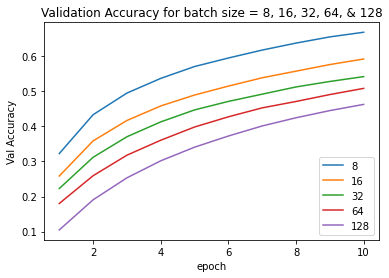

In [ ]:
# Opserving the impact of layers on depth on Conv2D

# layerList = [1,2,5,10,15,20,25,50,100, 200]#,75,100]
layerList02 = [50,100,150,200,500]
# fakeList = [10,50,200]

layerTesting(layerList02)

# Observing the impact of batch size
batchList = [8,16,32,64,128]
epoch = range(1,11)

batch01, b, c = dmModel(200,100,batchList[0],10,0.25) # five different batch sizes
batch02, b, c = dmModel(200,100,batchList[1],10,0.25) # one major player is timing, which is recorded by "hand"
batch03, b, c = dmModel(200,100,batchList[2],10,0.25)
batch04, b, c = dmModel(200,100,batchList[3],10,0.25)
batch05, b, c = dmModel(200,100,batchList[4],10,0.25)

plt.plot(epoch,batch01.history['val_accuracy'])
plt.plot(epoch,batch02.history['val_accuracy'])
plt.plot(epoch,batch03.history['val_accuracy'])
plt.plot(epoch,batch04.history['val_accuracy'])
plt.plot(epoch,batch05.history['val_accuracy'])
plt.title('Validation Accuracy for batch size = 8, 16, 32, 64, & 128')
plt.ylabel('Val Accuracy')
plt.xlabel('epoch')
plt.legend(['8', '16', '32', '64', '128'], loc='lower right')
plt.show()




Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 24, 24, 200)       5200      
                                                                 
 batch_normalization_30 (Bat  (None, 24, 24, 200)      800       
 chNormalization)                                                
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 12, 12, 200)      0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 12, 12, 200)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 10, 10, 100)       180100    
                                                                 
 batch_normalization_31 (Bat  (None, 10, 10, 100)    

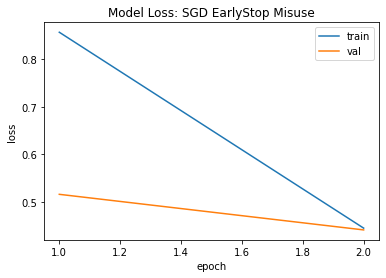

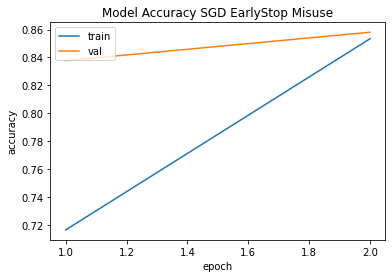

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 24, 24, 200)       5200      
                                                                 
 batch_normalization_32 (Bat  (None, 24, 24, 200)      800       
 chNormalization)                                                
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 12, 12, 200)      0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 12, 12, 200)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 10, 10, 100)       180100    
                                                                 
 batch_normalization_33 (Bat  (None, 10, 10, 100)    

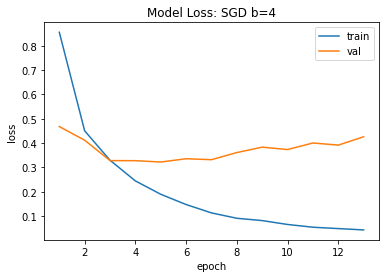

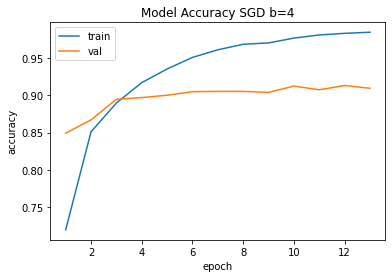

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 24, 24, 200)       5200      
                                                                 
 batch_normalization_34 (Bat  (None, 24, 24, 200)      800       
 chNormalization)                                                
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 12, 12, 200)      0         
 g2D)                                                            
                                                                 
 dropout_34 (Dropout)        (None, 12, 12, 200)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 10, 10, 100)       180100    
                                                                 
 batch_normalization_35 (Bat  (None, 10, 10, 100)    

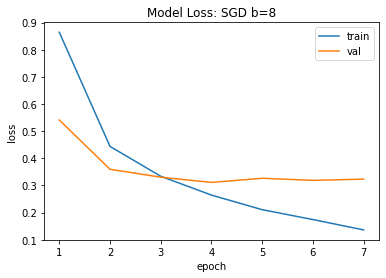

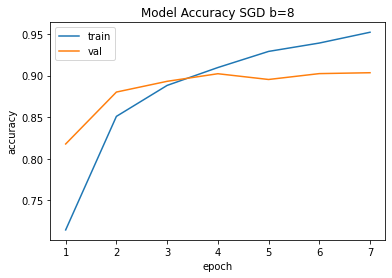

In [ ]:
# Early Stopping Example
sgdStop003, ssb003, ssc003 = dmModel(200,100,4,50,0.25,optimizer='SGD',earlyStop=True,modelName='SGDSTOP003',eStopPatience=0,eStopVal=0.1) # use of EarlyStopping that is too much!!!
modelPrinting(sgdStop003,'SGD EarlyStop Misuse') # this is OVERLY judicious

sgdStop004, ssb004, ssc004 = dmModel(200,100,4,50,0.25,optimizer='SGD',earlyStop=True,modelName='SGDSTOP004',eStopPatience=3,eStopVal=0.005) # use THIS as our best SGD example 
modelPrinting(sgdStop004,'SGD b=4') # good results! Or so we believe at least

sgdStop005b8, ssb005, ssc005 = dmModel(200,100,8,50,0.25,optimizer='SGD',earlyStop=True,modelName='SGDSTOP005',eStopPatience=3,eStopVal=0.005) # another SGD
modelPrinting(sgdStop005b8,'SGD b=8') # SGD, but with a batch of 8



Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 24, 24, 200)       5200      
                                                                 
 batch_normalization_36 (Bat  (None, 24, 24, 200)      800       
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 12, 12, 200)      0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 12, 12, 200)       0         
                                                                 
 conv2d_37 (Conv2D)          (None, 10, 10, 100)       180100    
                                                                 
 batch_normalization_37 (Bat  (None, 10, 10, 100)    

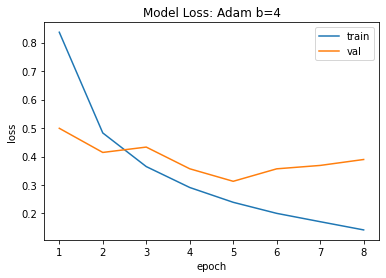

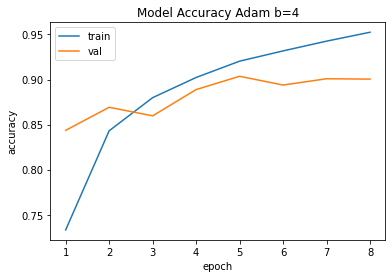

In [ ]:
# Adam Example

adam001, ab001, ac001 = dmModel(200,100,4,50,0.25,optimizer='Adam',earlyStop=True,modelName='ADAM001',eStopPatience=3,eStopVal=0.005) # useful Adam example
modelPrinting(adam001,'Adam b=4') # good results! Or so we believe at le

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 24, 24, 200)       5200      
                                                                 
 batch_normalization_38 (Bat  (None, 24, 24, 200)      800       
 chNormalization)                                                
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 12, 12, 200)      0         
 g2D)                                                            
                                                                 
 dropout_38 (Dropout)        (None, 12, 12, 200)       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 10, 10, 100)       180100    
                                                                 
 batch_normalization_39 (Bat  (None, 10, 10, 100)    

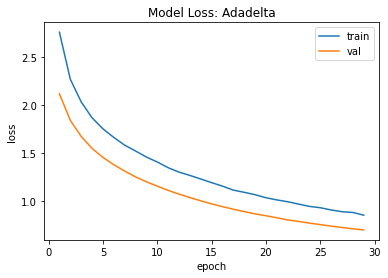

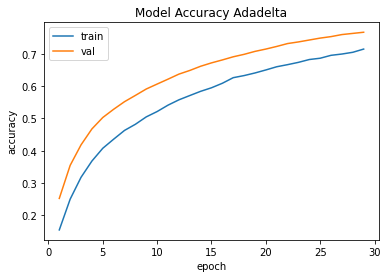

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 24, 24, 200)       5200      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 12, 12, 200)      0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 12, 12, 200)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 10, 10, 100)       180100    
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 5, 5, 100)        0         
 g2D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 5, 5, 100)       

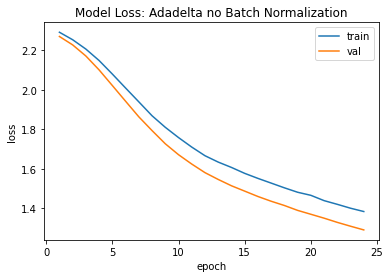

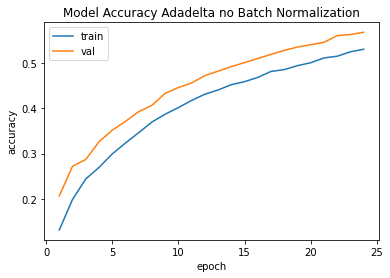

In [ ]:
# Default AdaDelta example

default001, db001, dc001 = dmModel(200,100,16,50,0.25,earlyStop=True,modelName='DEFAULT001',eStopPatience=2,eStopVal=0.01) # Default example, slow and not great
modelPrinting(default001,'Adadelta') # using b=16 here to due time considerations for adaDelta, less of a concern with SGD optimization

noBN, noBNb, noBNc = dmModel(200,100,16,50,0.25,earlyStop=True,modelName='NOBN',eStopPatience=2,eStopVal=0.01,batch=False) # Very bad!
modelPrinting(noBN,'Adadelta no Batch Normalization')


In [ ]:
## Evaluating with Testing Data

from tensorflow.keras import models

## LOAD DATA
data = np.load('./MNIST_CorrNoise.npz') #already evaluated

def testingResults(modelIn,modelNameIn):

  x_test = data['x_test']
  y_test = data['y_test']

  num_cls = len(np.unique(y_test))
  # print('Number of classes: ' + str(num_cls))

  # RESHAPE and standarize
  x_test = np.expand_dims(x_test/255,axis=3)

  # print('Shape of x_train: '+str(x_test.shape)+'\n')

  ## Define model parameters
  model_name = modelNameIn # To compare models, you can give them different names
  pweight='./weights/weights_' + model_name  + '.hdf5'
  print(pweight)

  model = models.load_model(pweight)

  # y_pred = model.predict_class(x_test)
  predict_x=model.predict(x_test) 
  y_pred=np.argmax(predict_x,axis=1)

  Acc_pred = sum(y_pred == y_test)/len(y_test)

  print('Accuracy in test set is: '+str(Acc_pred))

  return Acc_pred

# sgdAcc002 = testingResults(sgdStop,'SGD002')
#adamAcc = testingResults(adam,'Adam')
#adaDeltaAcc = testingResults(default,'Adadelta')
sgd004Acc = testingResults(sgdStop004,'SGDSTOP004')
adamResults = testingResults(adam001,'ADAM001')
sgd003Acc = testingResults(sgdStop003,'SGDSTOP003')
sgdStop005b8Acc = testingResults(sgdStop005b8,'SGDSTOP005')

defaultAcc = testingResults(default001,'DEFAULT001')
defaultNoBnAcc = testingResults(noBN,'NOBN')

# SGD vs Adam vs Default across 10 Epochs

plt.title('SGD and Adam Comparison for Validation Accuracy')
plt.plot(range(1,len(sgdStop004.history['val_accuracy'])+1),sgdStop004.history['val_accuracy'])
plt.plot(range(1,len(sgdStop005b8.history['val_accuracy'])+1),sgdStop005b8.history['val_accuracy'])
plt.plot(range(1,len(adam001.history['val_accuracy'])+1),adam001.history['val_accuracy'])
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['SGD b=4','SGD b=8','Adam'])
plt.show()
# plt.plot(range(10),default001.history['val_accuracy'][0:10])

# AdaDelta with and without Batch Normalization

plt.title('Adadelta Validation Accuracy with and without Batch Normalization')
plt.plot(range(1,len(default001.history['val_accuracy'])+1),default001.history['val_accuracy'])
plt.plot(range(1,len(noBN.history['val_accuracy'])+1),noBN.history['val_accuracy'])
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['With Batch Normlization','Without'])
plt.show()

In [ ]:
print(adam001.history['accuracy'][-1])
print(adam001.history['val_accuracy'][-1])
print(sgdStop004.history['accuracy'][-1])
print(sgdStop004.history['val_accuracy'][-1])
print(sgdStop005b8.history['accuracy'][-1])
print(sgdStop005b8.history['val_accuracy'][-1])
print(default001.history['accuracy'][-1])
print(default001.history['val_accuracy'][-1])
print(noBN.history['accuracy'][-1])
print(noBN.history['val_accuracy'][-1])